In [2]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [29]:
def loadData (flow, meta):
    df1 = pd.read_csv(f'{flow}', delim_whitespace=True, header=None)
    df1.columns = ['ID', 'Year', 'Mnth', 'Day', 'Flow0', 'SYM']
    df1['datetime'] = pd.to_datetime(df1[['Year', 'Mnth', 'Day']].rename(columns={'Year': 'year', 'Mnth': 'month', 'Day': 'day'}))
    df1.drop(['ID', 'Year', 'Mnth', 'Day'], axis=1, inplace=True)
    df2 = pd.read_csv(f'{meta}', skiprows=3, delim_whitespace=True)
    df = pd.concat([df1, df2], axis=1)
    df = pd.get_dummies(df, columns=['SYM'], dummy_na=True)
    df.set_index('datetime', inplace=True)
    df.drop(['Hr'], axis=1, inplace=True)
    before = 7
    after = 7
    for i in range(1, before + 1):
        df[f'Flow-{i}'] = df['Flow0'].shift(+i)  # Shift down by 1   
    for i in  range(1, after + 1):
        df[f'Flow+{i}'] = df['Flow0'].shift(-i)  # Shift up by 1   
    df = df.dropna()
    return df


df = loadData('Data/Idaho/13340000_streamflow_qc.txt', 'Data/Idaho/13340000_lump_maurer_forcing_leap.txt')


In [34]:
df.describe()

,Flow0,Year,Mnth,Day,dayl(s),prcp(mm/day),srad(W/m2),swe(mm),tmax(C),tmin(C),...,Flow-5,Flow-6,Flow-7,Flow+1,Flow+2,Flow+3,Flow+4,Flow+5,Flow+6,Flow+7
count,10586.000000,10586.000000,10586.000000,10586.000000,10586.000000,10586.000000,10586.000000,10586.0,10586.000000,10586.000000,...,10586.000000,10586.000000,10586.000000,10586.000000,10586.000000,10586.000000,10586.000000,10586.000000,10586.000000,10586.000000
mean,8414.381731,1994.009258,6.526261,15.738334,43198.684145,2.894924,378.598650,0.0,12.436173,-2.849776,...,8413.733705,8413.637351,8413.517381,8414.560268,8414.811544,8415.106272,8415.331098,8415.490742,8415.520026,8415.406669
std,10195.383846,8.362642,3.447168,8.798490,8879.386946,4.145166,137.538322,0.0,10.698922,6.720202,...,10195.743960,10195.799663,10195.871429,10195.283854,10195.147924,10194.991658,10194.864287,10194.773447,10194.758680,10194.801553
min,550.000000,1980.000000,1.000000,1.000000,30319.400000,0.000000,104.190000,0.0,-21.570000,-35.420000,...,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000
25%,2040.000000,1987.000000,4.000000,8.000000,34561.650000,0.050000,254.952500,0.0,3.022500,-6.920000,...,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000
50%,3760.000000,1994.000000,7.000000,16.000000,43200.000000,1.140000,384.740000,0.0,11.840000,-2.810000,...,3760.000000,3760.000000,3760.000000,3760.000000,3760.000000,3760.000000,3760.000000,3760.000000,3760.000000,3760.000000
75%,10900.000000,2001.000000,10.000000,23.000000,51838.350000,4.260000,488.467500,0.0,21.890000,2.290000,...,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000
max,80500.000000,2008.000000,12.000000,31.000000,56080.600000,41.530000,647.270000,0.0,35.600000,14.400000,...,80500.000000,80500.000000,80500.000000,80500.000000,80500.000000,80500.000000,80500.000000,80500.000000,80500.000000,80500.000000


In [32]:

Y = df[['Flow0']]  # Target variable
X = df.drop(['Flow0', 'Flow+1', 'Flow+2', 'Flow+3'], axis=1)  # Features

In [210]:
model = keras.Sequential([
    keras.layers.Dense(10, input_shape=(x_train.shape[1],), activation='relu'),
    keras.layers.Dense(10, activation='selu'),
    keras.layers.Dense(1)  # No activation function in the output layer for regression
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])


# Summary to see the architecture
model.summary()

model.fit(x_train, y_train, epochs=50)


y_pred_scaled = model.predict(x_test)

# Assuming Y_test is already scaled (y_test_scaled)
y_test_scaled = y_test  # If y_test is already scaled, otherwise scale it before this step.


# Inverse transform predictions
y_pred = scaler_Y.inverse_transform(y_pred_scaled)
y_pred = np.maximum(y_pred, 0)  # Ensure no negative predictions

# Inverse transform y_test
y_test = scaler_Y.inverse_transform(y_test_scaled)
y_test = np.maximum(y_test, 0)  # Ensure no negative values


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 10)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271 (1.06 KB)

 Trainable params: 271 (1.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 983us/step - loss: 0.7711 - mean_squared_error: 0.7711
Epoch 2/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1070 - mean_squared_error: 0.1070
Epoch 3/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 0.0834 - mean_squared_error: 0.0834
Epoch 4/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 0.0763 - mean_squared_error: 0.0763
Epoch 5/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 0.0777 - mean_squared_error: 0.0777
Epoch 6/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 0.0657 - mean_squared_error: 0.0657
Epoch 7/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0694 - mean_squared_error: 0.0694
Epoch 8/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 0.0638 - mean_squared_error: 0.0638
Epoch 9/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 0.0623 - mean_squared_error: 0.0623
Epoch 10/50
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 0.0540 - mean_squared_error: 0.0540
Epoch 11/50
265/265 ━━━

In [35]:
def backtest(df, model, X, Y, start=3650, step=90):
    all_predictions = []
    for i in range(start, df.shape[0], step):
        train = df.iloc[:i,:]
        test = df.iloc[i:(i+step),:]

        model.fit(train[X], train[Y])
        
        preds = model.predict(test[X])

        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["Y"], preds], axis=1)

        combined.columns = ["actual", "prediction"]
        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()

        all_predictions.append(combined)
    return pd.concat(all_predictions, axis=0)

In [209]:
 
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
# Y_scaled = scaler_Y.fit_transform(Y.values.reshape(-1, 1)).flatten()
Y_scaled = scaler_Y.fit_transform(Y)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y_scaled, test_size=0.20, random_state=3)

In [211]:
# Initialize lists to store the metrics
mae_list = []
mse_list = []
rmse_list = []
r2_list = []
mape_list = []
accuracy_list = []

# Small value to avoid division by zero
epsilon = 1e-10

# Check if it's a single output or multiple outputs
if len(y_pred.shape) == 1 or y_pred.shape[1] == 1:
    y_pred = np.expand_dims(y_pred, axis=-1)  # Ensure y_pred has shape (n_samples, 1)
    y_test = np.expand_dims(y_test, axis=-1)  # Ensure y_test has shape (n_samples, 1)

# Now your loop should work fine even for single output
for i in range(y_pred.shape[1]):
    # Calculate errors
    errors = abs(y_pred[:, i] - y_test[:, i])

    # Mean Absolute Error (MAE)
    mae = np.mean(errors)
    mae_list.append(mae)
    print(f"Mean Absolute Error (Flow +{i}): {round(mae, 2)} m3/s")

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    mse_list.append(mse)
    print(f"Mean Squared Error (Flow +{i}): {round(mse, 2)}")

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    rmse_list.append(rmse)
    print(f"Root Mean Squared Error (Flow +{i}): {round(rmse, 2)}")

    # R-squared (R²)
    r_squared = r2_score(y_test[:, i], y_pred[:, i])
    r2_list.append(r_squared)
    print(f"R-squared (Flow +{i}): {round(r_squared, 2)}")

    # Mean Absolute Percentage Error (MAPE)
    mape = 100 * (errors / (y_test[:, i] + epsilon))  # Add epsilon to avoid division by zero
    mean_mape = np.mean(mape)
    mape_list.append(mean_mape)
    print(f"MAPE (Flow +{i}): {round(mean_mape, 2)}%")
    
    # Calculate accuracy (100% - MAPE)
    accuracy = 100 - mean_mape
    accuracy_list.append(accuracy)
    print(f"Accuracy (Flow +{i}): {round(accuracy, 2)}%\n")


Mean Absolute Error (Flow +0): 1093.22 m3/s
Mean Squared Error (Flow +0): 4734420.92
Root Mean Squared Error (Flow +0): 2175.87
R-squared (Flow +0): 0.95
MAPE (Flow +0): 19.11%
Accuracy (Flow +0): 80.89%



In [212]:
# # Initialize lists to store the metrics
# mae_list = []
# mse_list = []
# rmse_list = []
# r2_list = []
# mape_list = []
# accuracy_list = []

# # Small value to avoid division by zero
# epsilon = 1e-10


# # Calculate errors
# errors = abs(y_pred - y_test)

# # Mean Absolute Error (MAE)
# mae = np.mean(errors)
# mae_list.append(mae)
# print(f"Mean Absolute Error (Flow +0): {round(mae, 2)} m3/s")

# # Mean Squared Error (MSE)
# mse = mean_squared_error(y_test, y_pred)
# mse_list.append(mse)
# print(f"Mean Squared Error (Flow +0): {round(mse, 2)}")

# # Root Mean Squared Error (RMSE)
# rmse = np.sqrt(mse)
# rmse_list.append(rmse)
# print(f"Root Mean Squared Error (Flow +0): {round(rmse, 2)}")

# # R-squared (R²)
# r_squared = r2_score(y_test, y_pred)
# r2_list.append(r_squared)
# print(f"R-squared (Flow +0): {round(r_squared, 2)}")

# # Mean Absolute Percentage Error (MAPE)
# mape = 100 * (errors / (y_test + epsilon))  # Add epsilon to avoid division by zero
# mean_mape = np.mean(mape)
# mape_list.append(mean_mape)
# print(f"MAPE (Flow +0): {round(mean_mape, 2)}%")

# # Calculate accuracy (100% - MAPE)
# accuracy = 100 - mean_mape
# accuracy_list.append(accuracy)
# print(f"Accuracy (Flow +0): {round(accuracy, 2)}%\n")


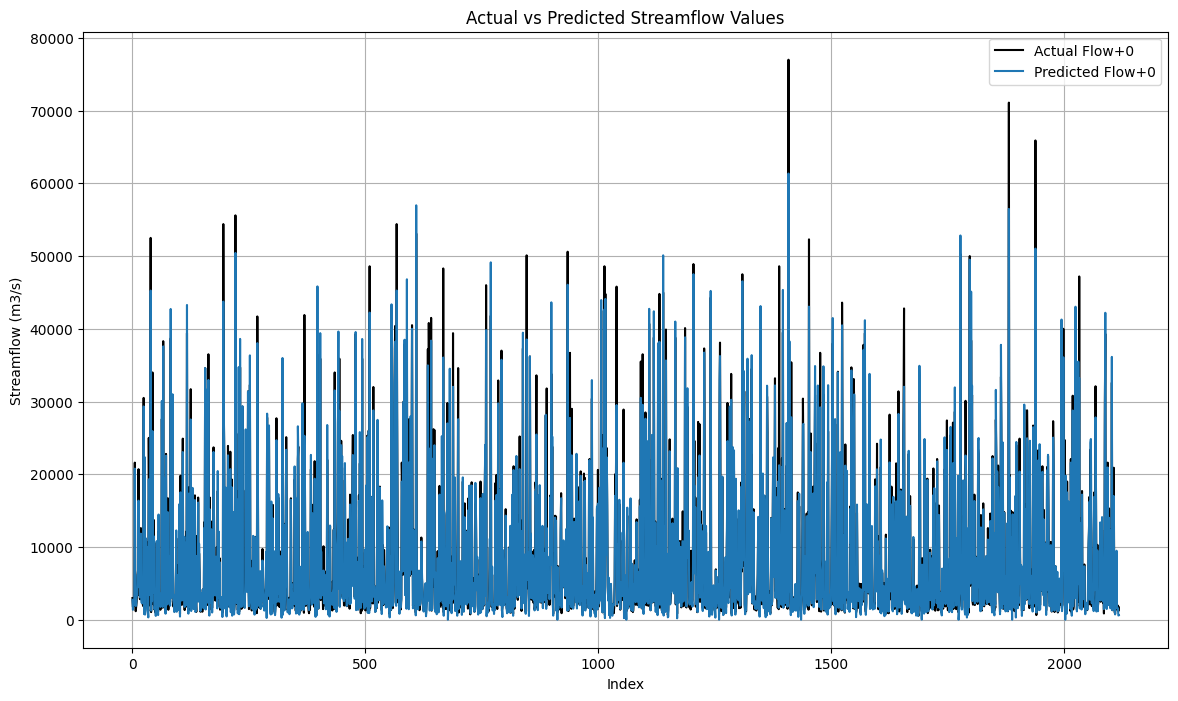

In [213]:
plt.figure(figsize=(14, 8))

# Plot Actual vs Predicted for each Flow
for i in range(y_pred.shape[1]):
    plt.plot(range(len(y_test)), y_test[:, i], label=f'Actual Flow+{i}', color='black')
    plt.plot(range(len(y_pred)), y_pred[:, i], label=f'Predicted Flow+{i}', color=f'C{i}')

# plt.plot(range(len(y_test)), y_test, label=f'Actual Flow+0', color='black')
# plt.plot(range(len(y_pred)), y_pred, label=f'Predicted Flow+0', color=f'C0')

plt.xlabel('Index')
plt.ylabel('Streamflow (m3/s)')
plt.title('Actual vs Predicted Streamflow Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [214]:
# # Fit the model with validation split to get training and validation loss
# history = model.fit(x_train, y_train, epochs=100, validation_split=0.2)

# # Plot training & validation loss values
# plt.figure(figsize=(10, 6))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(loc='upper right')
# plt.show()


265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step


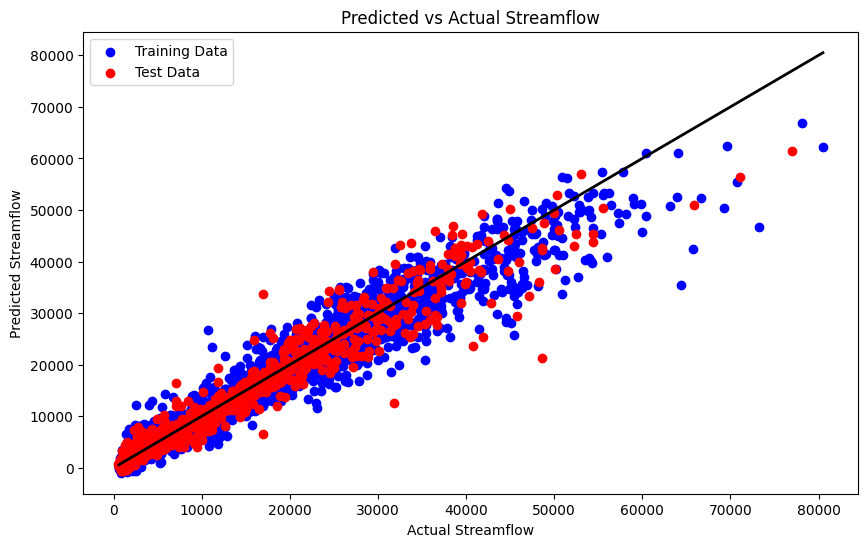

In [215]:
# Make predictions
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

# Reverse the scaling to compare actual values
y_train_actual = scaler_Y.inverse_transform(y_train)
y_pred_train_actual = scaler_Y.inverse_transform(y_pred_train)

y_test_actual = y_test
y_pred_test_actual = scaler_Y.inverse_transform(y_pred_test)

# Plot predicted vs actual streamflow for training data
plt.figure(figsize=(10, 6))
plt.scatter(y_train_actual, y_pred_train_actual, color='blue', label='Training Data')
plt.scatter(y_test_actual, y_pred_test_actual, color='red', label='Test Data')
plt.plot([min(y_train_actual), max(y_train_actual)], [min(y_train_actual), max(y_train_actual)], color='black', linewidth=2)
plt.title('Predicted vs Actual Streamflow')
plt.xlabel('Actual Streamflow')
plt.ylabel('Predicted Streamflow')
plt.legend(loc='upper left')
plt.show()


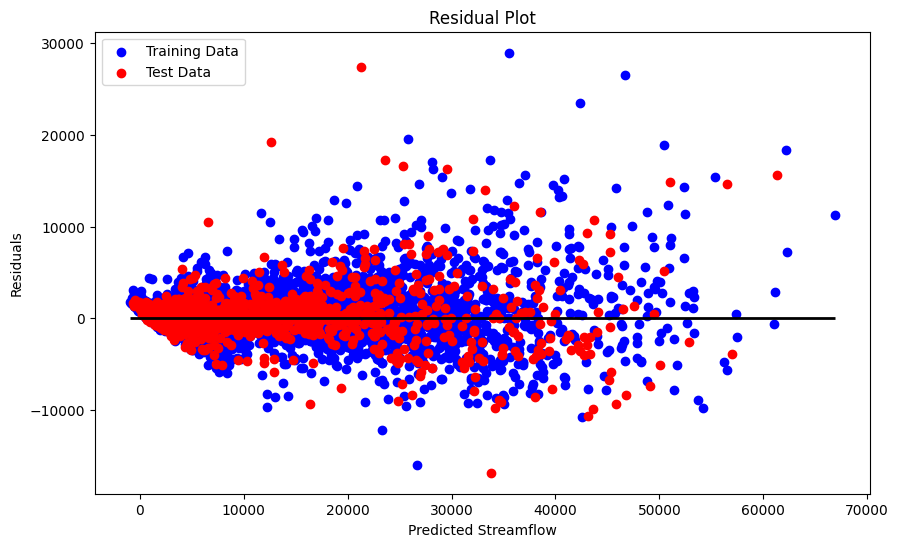

In [216]:
# Calculate residuals
residuals_train = y_train_actual.flatten() - y_pred_train_actual.flatten()
residuals_test = y_test_actual.flatten() - y_pred_test_actual.flatten()

# Plot residuals for training and test data
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_train_actual.flatten(), residuals_train, color='blue', label='Training Data')
plt.scatter(y_pred_test_actual.flatten(), residuals_test, color='red', label='Test Data')
plt.hlines(y=0, xmin=min(y_pred_train_actual), xmax=max(y_pred_train_actual), color='black', linewidth=2)
plt.title('Residual Plot')
plt.xlabel('Predicted Streamflow')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.show()


# from sklearn.inspection import permutation_importance

# # Calculate permutation importance
# perm_importance = permutation_importance(model, x_test, y_test, n_repeats=10, random_state=42)

# # Plot feature importances
# feature_names = X.columns
# sorted_idx = perm_importance.importances_mean.argsort()

# plt.figure(figsize=(10, 6))
# plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel('Permutation Importance')
# plt.title('Feature Importance')
# plt.show()


# Read the .txt file into a DataFrame
# If the delimiter is not a comma, adjust the 'delimiter' parameter accordingly
new_df1 = pd.read_csv('Data/Idaho/05131500_streamflow_qc.txt', delim_whitespace=True, header=None)  # For whitespace-separated

# Assign column headers
new_df1.columns = ['ID', 'Year', 'Mnth', 'Day', 'Flow0', 'SYM']

new_df1.drop(['ID', 'Year', 'Mnth', 'Day'], axis=1, inplace=True)

# If the delimiter is not a comma, adjust the 'delimiter' parameter accordingly
new_df2 = pd.read_csv('Data/Idaho/05131500_lump_maurer_forcing_leap.txt', skiprows=3, delim_whitespace=True)  # For whitespace-separated


# Concatenate horizontally
new_df = pd.concat([new_df1, new_df2], axis=1)

new_df = pd.get_dummies(new_df, columns=['SYM'], dummy_na=True)

new_df.drop(['Mnth', 'Day', 'Hr'], axis=1, inplace=True)


# # Create new columns with flow values before 1 day, 2 days, 3 days
new_df['Flow-1'] = new_df['Flow0'].shift(+1)  # Shift up by 1
new_df['Flow-2'] = new_df['Flow0'].shift(+2)  # Shift up by 2
new_df['Flow-3'] = new_df['Flow0'].shift(+3)  # Shift up by 3
# # Create new columns with flow values after 1 day, 2 days, 3 days
new_df['Flow+1'] = new_df['Flow0'].shift(-1)  # Shift up by 1
new_df['Flow+2'] = new_df['Flow0'].shift(-2)  # Shift up by 2
new_df['Flow+3'] = new_df['Flow0'].shift(-3)  # Shift up by 3

new_df = new_df.dropna()

Y2 = new_df[['Flow+1']]  # Target variable
X2 = new_df.drop(['Flow0', 'Flow+1', 'Flow+2', 'Flow+3'], axis=1)  # Features


scaler_X2 = StandardScaler()
scaler_Y2 = StandardScaler()

X_scaled2 = scaler_X.fit_transform(X2)
# Y_scaled = scaler_Y2.fit_transform(Y2.values.reshape(-1, 1)).flatten()
Y_scaled2 = scaler_Y.fit_transform(Y2)


y_pred_scaled2 = model.predict(X_scaled2)

# Inverse transform predictions
y_pred2 = scaler_Y.inverse_transform(y_pred_scaled2)
y_pred2 = np.maximum(y_pred2, 0)  # Ensure no negative predictions


# Initialize lists to store the metrics
mae_list = []
mse_list = []
rmse_list = []
r2_list = []
mape_list = []
accuracy_list = []

# Small value to avoid division by zero
epsilon = 1e-10

# Loop through each target variable (Flow0, Flow+1, etc.)
for i in range(y_pred.shape[1]):
    # Calculate errors
    errors = abs(y_pred[:, i] - y_test[:, i])

    # Mean Absolute Error (MAE)
    mae = np.mean(errors)
    mae_list.append(mae)
    print(f"Mean Absolute Error (Flow +{i}): {round(mae, 2)} m3/s")

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    mse_list.append(mse)
    print(f"Mean Squared Error (Flow +{i}): {round(mse, 2)}")

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    rmse_list.append(rmse)
    print(f"Root Mean Squared Error (Flow +{i}): {round(rmse, 2)}")

    # R-squared (R²)
    r_squared = r2_score(y_test[:, i], y_pred[:, i])
    r2_list.append(r_squared)
    print(f"R-squared (Flow +{i}): {round(r_squared, 2)}")

    # Mean Absolute Percentage Error (MAPE)
    mape = 100 * (errors / (y_test[:, i] + epsilon))  # Add epsilon to avoid division by zero
    mean_mape = np.mean(mape)
    mape_list.append(mean_mape)
    print(f"MAPE (Flow +{i}): {round(mean_mape, 2)}%")
    
    # Calculate accuracy (100% - MAPE)
    accuracy = 100 - mean_mape
    accuracy_list.append(accuracy)
    print(f"Accuracy (Flow +{i}): {round(accuracy, 2)}%\n")


# Define the range of indices you want to plot
start_index = 2000
end_index = 2100



# Ensure indices are within bounds
start_index = max(start_index, 0)
end_indexY = min(end_index, len(Y2))
end_indexX = min(end_index, len(X2))

# Slice the arrays
Y2_subset = Y2.iloc[start_index:end_indexY]
y_pred2_subset = y_pred2[start_index:end_indexY]
X2_subset = X2[start_index:end_indexX]

plt.figure(figsize=(14, 8))

# Plot Actual vs Predicted for each Flow
#Define a color map for features
colors = plt.cm.BuPu(np.linspace(0, 1, X2.shape[1]))

# Plot each feature with a different color
for i in range(2, X2.shape[1]):
    plt.plot(range(len(X2_subset)), X2_subset.iloc[:, i], color=colors[i], label=f'Feature {i+1}')
plt.plot(range(len(Y2_subset)), Y2_subset.iloc[:, 0], color='orange', label='Actual Values')
# plt.plot(range(len(Y2_subset)), Y2_subset[:, 1], color='blue', label='Actual Values')
# plt.plot(range(len(Y2_subset)), Y2_subset[:, 2], color='blue', label='Actual Values')
# plt.plot(range(len(Y2_subset)), Y2_subset[:, 3], color='blue', label='Actual Values')
# plt.plot(range(len(X2_subset)), X2_subset.iloc[:, 0], color='green', label='Feature')
# plt.plot(range(len(X2_subset)), X2_subset.iloc[:, 1], color='green', label='Feature')
# plt.plot(range(len(X2_subset)), X2_subset.iloc[:, 2], color='green', label='Feature')
# plt.plot(range(len(X2_subset)), X2_subset.iloc[:, 3], color='green', label='Feature')
# plt.plot(range(len(Y_pred2_subset)), Y_pred2_subset, color='red', label='Predicted Flow0')
plt.plot(range(len(y_pred2_subset)), y_pred2_subset[:, 0], color='red', label='Predicted Flow0')
# plt.plot(range(len(Y_pred2_subset)), Y_pred2_subset[:, 1], color='red', label='Predicted Flow+1')
# plt.plot(range(len(Y_pred2_subset)), Y_pred2_subset[:, 2], color='red', label='Predicted Flow+2')
# plt.plot(range(len(Y_pred2_subset)), Y_pred2_subset[:, 3], color='red', label='Predicted Flow+3')

plt.xlabel('Index')
plt.ylabel('Streamflow (m3/s)')
plt.title('Actual vs Predicted Streamflow Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
